Loading model...
Loading datasets...

===== Testing 0% pruning =====


Evaluating MMLU:   0%|          | 0/1404 [00:00<?, ?it/s]/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warn

Prune 0% → MMLU=0.0000, GSM8K=0.0840

===== Testing 10% pruning =====
Applied 10% global magnitude pruning.


Evaluating GSM8K: 100%|██████████| 131/131 [13:39<00:00,  6.25s/it]


Prune 10% → MMLU=0.0000, GSM8K=0.0763

===== Testing 20% pruning =====
Applied 20% global magnitude pruning.


Evaluating GSM8K: 100%|██████████| 131/131 [13:51<00:00,  6.35s/it]


Prune 20% → MMLU=0.0000, GSM8K=0.0458

===== Testing 30% pruning =====
Applied 30% global magnitude pruning.


Evaluating GSM8K: 100%|██████████| 131/131 [13:46<00:00,  6.31s/it]


Prune 30% → MMLU=0.0000, GSM8K=0.0000

===== Testing 40% pruning =====
Applied 40% global magnitude pruning.


Evaluating GSM8K: 100%|██████████| 131/131 [13:36<00:00,  6.23s/it]


Prune 40% → MMLU=0.0000, GSM8K=0.0305

===== Testing 50% pruning =====
Applied 50% global magnitude pruning.


Evaluating GSM8K: 100%|██████████| 131/131 [13:46<00:00,  6.31s/it]


Prune 50% → MMLU=0.0000, GSM8K=0.0000

===== Testing 60% pruning =====
Applied 60% global magnitude pruning.


Evaluating GSM8K: 100%|██████████| 131/131 [38:22<00:00, 17.58s/it]


Prune 60% → MMLU=0.0000, GSM8K=0.0076

===== Testing 70% pruning =====
Applied 70% global magnitude pruning.


Evaluating GSM8K: 100%|██████████| 131/131 [38:20<00:00, 17.56s/it]


Prune 70% → MMLU=0.0000, GSM8K=0.0076

===== Testing 80% pruning =====
Applied 80% global magnitude pruning.


Evaluating GSM8K: 100%|██████████| 131/131 [38:41<00:00, 17.72s/it]


Prune 80% → MMLU=0.0000, GSM8K=0.0076

===== Testing 90% pruning =====
Applied 90% global magnitude pruning.


Evaluating GSM8K: 100%|██████████| 131/131 [38:47<00:00, 17.76s/it]

Prune 90% → MMLU=0.0000, GSM8K=0.0076
Saved results → global_pruning_results.csv


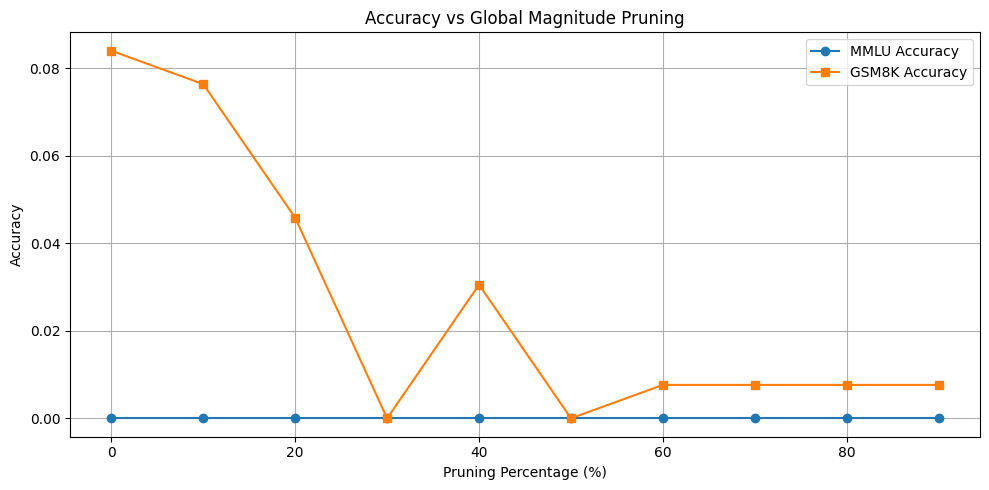

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
from tqdm import tqdm
import copy
import math

# ============================================================
# 1. LOAD MODEL
# ============================================================
model_name = "Qwen/Qwen3-0.6B"

print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# ============================================================
# 2. LOAD DATASETS (10% SAMPLE)
# ============================================================
print("Loading datasets...")

mmlu = load_dataset("cais/mmlu", "all", split="test")
gsm8k = load_dataset("gsm8k", "main", split="test")

mmlu_10 = mmlu.shuffle(seed=42).select(range(int(0.1 * len(mmlu))))
gsm8k_10 = gsm8k.shuffle(seed=42).select(range(int(0.1 * len(gsm8k))))

# ============================================================
# 3. EVALUATION FUNCTIONS
# ============================================================

def eval_mmlu(model, tokenizer, dataset):
    correct = 0

    for row in tqdm(dataset, desc="Evaluating MMLU"):
        question = row["question"]
        options = row["choices"]
        answer = row["answer"]

        prompt = "Answer the following multiple-choice question.\n\n"
        prompt += f"Question: {question}\n"
        for i, c in enumerate(options):
            prompt += f"{chr(65+i)}. {c}\n"
        prompt += "\nAnswer:"

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        output = model.generate(
            **inputs,
            max_new_tokens=2,
            do_sample=False
        )

        response = tokenizer.decode(output[0], skip_special_tokens=True)
        pred = response.strip()[-1:].upper()

        if pred == answer:
            correct += 1

    return correct / len(dataset)


def extract_last_number(text):
    nums = re.findall(r"-?\d+\.?\d*", text)
    return nums[-1] if nums else None


def eval_gsm8k(model, tokenizer, dataset):
    correct = 0

    for row in tqdm(dataset, desc="Evaluating GSM8K"):
        question = row["question"]
        gold_answer = row["answer"]

        prompt = (
            "Solve the following math word problem. "
            "Give only the final numeric answer.\n\n"
            f"{question}\n\nAnswer:"
        )

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        output = model.generate(
            **inputs,
            max_new_tokens=200,
            do_sample=False
        )

        response = tokenizer.decode(output[0], skip_special_tokens=True)

        pred = extract_last_number(response)
        gold = extract_last_number(gold_answer)

        if pred == gold:
            correct += 1

    return correct / len(dataset)


# Optional — perplexity (not required by your report)
def compute_perplexity(model, tokenizer, dataset):
    total_loss = 0
    total_tokens = 0
    loss_fct = torch.nn.CrossEntropyLoss(reduction="sum")

    for row in dataset:
        text = row["question"] if "question" in row else row["text"]
        enc = tokenizer(text, return_tensors="pt").to(model.device)
        input_ids = enc["input_ids"]

        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss

        total_loss += loss.item() * input_ids.numel()
        total_tokens += input_ids.numel()

    avg_loss = total_loss / total_tokens
    return math.exp(avg_loss)


# ============================================================
# 4. GLOBAL MAGNITUDE PRUNING
# ============================================================
def prune_global_magnitude(model, p):
    assert 0 <= p < 100

    if p == 0:
        return model

    weight_list = []
    for name, param in model.named_parameters():
        if "weight" in name and param.requires_grad:
            weight_list.append(param.data.view(-1))

    all_weights = torch.cat(weight_list)
    k = int((p / 100) * all_weights.numel())

    threshold = torch.topk(all_weights.abs(), k, largest=False).values.max()

    for name, param in model.named_parameters():
        if "weight" in name and param.requires_grad:
            mask = (param.data.abs() >= threshold).float()
            param.data = param.data * mask

    print(f"Applied {p}% global magnitude pruning.")
    return model


# ============================================================
# 5. PRUNING LOOP
# ============================================================
pruning_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
results = []

for p in pruning_levels:
    print(f"\n===== Testing {p}% pruning =====")

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto"
    )

    model = prune_global_magnitude(model, p)

    mmlu_score = eval_mmlu(model, tokenizer, mmlu_10)
    gsm8k_score = eval_gsm8k(model, tokenizer, gsm8k_10)

    print(f"Prune {p}% → MMLU={mmlu_score:.4f}, GSM8K={gsm8k_score:.4f}")

    results.append({
        "pruning_percent": p,
        "mmlu_accuracy": mmlu_score,
        "gsm8k_accuracy": gsm8k_score
    })


df = pd.DataFrame(results)
df.to_csv("global_pruning_results.csv", index=False)
print("Saved results → global_pruning_results.csv")


# ============================================================
# 6. PLOTTING
# ============================================================
plt.figure(figsize=(10, 5))

plt.plot(df["pruning_percent"], df["mmlu_accuracy"], marker='o', label="MMLU Accuracy")
plt.plot(df["pruning_percent"], df["gsm8k_accuracy"], marker='s', label="GSM8K Accuracy")

plt.xlabel("Pruning Percentage (%)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Global Magnitude Pruning")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# If perplexity was added later:
if "perplexity" in df.columns:
    plt.figure(figsize=(6, 5))
    plt.plot(df["pruning_percent"], df["perplexity"], marker='o')
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Perplexity")
    plt.title("Perplexity vs Global Magnitude Pruning")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
